In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
from io import BytesIO
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg

## 1. Load Data

In [2]:
OD_matrixDF=pd.read_csv('data/simulation/od_matrixDF.csv')#sample mobility data
socialeco_province=pd.read_csv('data/simulation/province_data.csv')
socialeco_province=socialeco_province[['province','pop_18_m','beds_hospital','province_cn']]
                      

In [3]:
# preprocessing the CSV
OD_matrixDF.index=OD_matrixDF['from_province']
OD_matrixDF=OD_matrixDF.drop(columns=['from_province'], axis=1)

In [4]:
OD_matrixDF

,上海,云南,内蒙古自治区,北京,吉林,四川,天津,宁夏回族自治区,安徽,山东,...,湖南,甘肃,福建,西藏自治区,贵州,辽宁,重庆,陕西,青海,黑龙江
from_province,,,,,,,,,,,,,,,,,,,,,
上海,0.000000,244.173374,179.620359,2171.115381,283.453895,804.923900,360.304006,84.900450,4150.099071,1948.613557,...,516.488886,174.139591,1074.028920,11.333512,209.164291,595.622897,506.312572,513.114977,41.652646,393.338624
云南,415.063156,0.000000,42.109729,539.811159,44.612775,5394.112210,87.417673,41.772283,184.049083,415.756549,...,394.066693,57.013624,1266.203761,148.639188,5316.288406,97.097924,1412.598512,199.273981,20.597449,58.540360
内蒙古自治区,10.000000,4.131907,0.000000,3641.690470,1737.630071,3.975977,972.292864,1620.174774,5.880057,370.154991,...,10.000000,554.627655,10.000000,1.870128,10.000000,3975.746482,10.000000,2338.186621,6.481498,2097.133238
北京,2371.233690,423.149411,2297.288774,0.000000,817.410569,1299.045308,6172.893587,247.949124,1085.471515,5247.131829,...,737.590998,392.795163,766.981264,35.816045,276.307597,2200.627213,615.257540,1246.586647,100.015147,1342.205729
吉林,352.430077,16.653811,1978.953736,1868.316945,0.000000,100.745273,916.382581,10.940346,49.564872,1545.658848,...,55.179533,1.973030,42.117214,2.123828,10.000000,6328.613584,10.000000,8.988667,0.962215,4074.166820
四川,2892.182809,9406.159976,160.768695,1993.793665,114.991358,0.000000,238.914465,167.570370,379.525889,1117.616891,...,807.472298,1222.942196,6832.265371,1408.321193,6403.046873,405.813661,27119.144971,3978.107284,410.787077,157.692906
天津,490.767036,67.408500,455.254822,6785.459149,288.524479,232.592917,0.000000,42.184282,274.432633,2384.207727,...,90.521420,94.411057,150.228594,4.971672,31.207793,746.935295,148.636717,250.972077,18.670451,434.267965
宁夏回族自治区,10.000000,10.000000,1454.144133,309.206614,1.948949,45.241205,10.000000,0.000000,5.383519,54.722952,...,10.000000,1786.213328,10.000000,2.856449,10.000000,3.767440,10.000000,1334.436015,70.027327,14.348470
安徽,28226.281264,175.930518,176.478078,3420.244723,142.563491,304.575463,1249.667368,115.067434,0.000000,4188.098326,...,506.072416,137.163829,3341.157620,26.626847,134.403025,712.408932,199.917663,1014.096753,85.183950,180.436499


## 2. SEIR Model Parameter

### 2.1 Set up parameters with hospital resource

In [5]:
#Parameter β represents the rate of conversion from “susceptable” to “exposed”
beta= 0.625

#from "exposed" to "infected" with a rate of α: alpha
alpha=1/7 #This could change per serious of the disease

#Parameter γ determines the rate of recovery, 
#while the recovered subjects are removed from the repository of susceptible subjects. 
gamma= 0.15

locs_len,_=OD_matrixDF.shape #get data length
mobility_factor=20 #adjust this to control inflow out flow


Nc=socialeco_province ['pop_18_m'].values.T #get population column
R0=beta/gamma
R0
#here R0 is static, but eventually we will model a dynamic function of R0

4.166666666666667

In [6]:
#add hospital beds 
add_beds=np.full(locs_len,5000)

#obeds: current number of beds could be used
obeds=socialeco_province.beds_hospital.values

#beds_available_rate: percentage of empty beds could be used in case of emergency, 
#consider other patients still need to stay
beds_available_rate=0.3
obeds=socialeco_province.beds_hospital.values*beds_available_rate

#daily get into hospital, this is based on the empirical studies that only 20% infected 
#people will need to get into hospital eventually. and not everyone's syndrome is detectable, thus we set the rate very low
#further cases should consider that younger teenagers will not need to get into hospital at all
in_hospital_rate=0.2

### 2.2 Set up the SEIR model

In [7]:
def SEIR_Model(seir,OD_matrixDF):
    '''Typical SEIR Model, does not include other factors'''
    seir_previous=seir.copy()
    flow_infected_matrix=OD_matrixDF*mobility_factor/Nc * seir_previous[:,2]
    inflow_infected_sum=flow_infected_matrix.sum(axis=1)#infected and outside
    total_infected=seir_previous[:,2]+inflow_infected_sum#infected and outside
    
    
    new_S=-1*beta*(total_infected)*seir_previous[:,0]/Nc
    new_E=beta*(total_infected)*seir_previous[:,0]/Nc - alpha* seir_previous[:,1]
    
    
    new_I = alpha*seir_previous[:,1] - gamma*seir_previous[:,2]
    new_R = gamma*seir_previous[:,2]

    
    
    seir[:,0]=seir[:,0]+new_S
    seir[:,1]=seir[:,1]+new_E
    seir[:,2]=seir[:,2]+new_I
    seir[:,3]=seir[:,3]+new_R
    
    return seir

In [8]:
def SEIR_Model_nbeds(seir,OD_matrixDF,nbeds):
    '''Typical SEIR Model + number of beds could serve patients in each province.
    In this case, we could also interpretate number of people in beds as number of people being quanrantined.'''
    seir_previous=seir.copy()
    flow_infected_matrix=OD_matrixDF*mobility_factor/Nc * seir_previous[:,2]
    
    inflow_infected_sum=flow_infected_matrix.sum(axis=1)#infected and outside
    total_infected=seir_previous[:,2]+inflow_infected_sum#infected and outside
    
    #number of people in beds:
    new_S=-1*beta*(total_infected)*seir_previous[:,0]/Nc
    new_E=beta*(total_infected)*seir_previous[:,0]/Nc - alpha* seir_previous[:,1]
    
    #notfull, identify the places that beds are not full yet.
    notfull_index=np.where(seir_previous[:,4]<nbeds)
    
    #new infected people needs to get a bed in hospital
    new_B_in=np.zeros([locs_len,])
    new_B_in[notfull_index]=seir_previous[:,2][notfull_index]*in_hospital_rate#rate getting into hospital
    
    #people infected but stay outside without changing 
    new_I = alpha*seir_previous[:,1] - gamma*seir_previous[:,2]*0.8-new_B_in 
    # 0.8:here we assume if you are infected, but you not in hospital, your chance of getting recovered reduce by 20% 
    
    #actual change of number of beds being used.
    new_B = new_B_in-seir_previous[:,4]*gamma
    
    #number of people infected
    new_R = gamma*seir_previous[:,2]*0.8+seir_previous[:,4]*gamma


    
    seir[:,0]=seir[:,0]+new_S
    seir[:,1]=seir[:,1]+new_E
    seir[:,2]=seir[:,2]+new_I 
    seir[:,3]=seir[:,3]+new_R
    seir[:,4]=seir[:,4]+new_B

    
    return seir

In [9]:
new_df = pd.DataFrame({'湖北': np.zeros(31)})
def update_mobility(matrix,stop_province='湖北',mobility_fc=0.7):
    '''This function update the mobility matrix after the day Hubei was isolated.
    matri: current OD matrix
    stop_province: it is Hubei by default for this time
    mobility_fc: percentage of default value; assume that mobility between other city will also decrease'''
    
    newmatrix=matrix.copy()*mobility_fc
    newmatrix[stop_province]=0
    newmatrix.loc[stop_province,:]=0
    
    return newmatrix


In [11]:
# This process didn't consider individual quanrantine, only includes Hubei's city level quanrantine
def run(OD_matrix,beta, gamma, alpha,quarantine_start=290,T=300, addbeds=False):
    """this function run the SEIR model using the pre-definde parameter,
    
    quarantine_start: on which day city-level quarantine was started at Hubei
    quarantine: Boolean if there is quarantine or not
    T: length of time for simulation
    addbeds: if there will be additional beds or not
    
    """

    #innitiate initial#population of different province
    SEIR=np.zeros([locs_len,6])
    SEIR[:,0]=Nc
    
    SEIR[:,1][20]=1# Hubei's index is 20
    first_exposed=SEIR[:,1].copy()
    SEIR[:, 0] = SEIR[:, 0] - first_exposed # suscepticles -1
    
    SEIR[:, 2] = SEIR[:, 2] + first_exposed*alpha# move infections to the I group


    
    output=pd.DataFrame({"day":[],"province_en":[],"province_cn":[],"susceptics":[],"exposed":[],"infected":[],"recover":[],
                         "in_hospital":[]})
    provincelist_cn=socialeco_province.province_cn.unique()
    provincelist_en=socialeco_province.province.unique()
    
    OD_matrix_norm=OD_matrix.copy()
    OD_matrix_update=update_mobility(OD_matrix,stop_province='湖北',mobility_fc=0.7)
    # reduce other province's mobility by 0.7 as well
    
    if addbeds:
        nbeds=obeds+add_beds
    else:
        nbeds=obeds
        

    for i in range(T):
        if i<quarantine_start:
            SEIR=SEIR_Model_nbeds(SEIR,OD_matrix_norm,nbeds)

        else:
            SEIR=SEIR_Model_nbeds(SEIR,OD_matrix_update,nbeds)
        day=np.full(locs_len,i)
        new=pd.DataFrame({"day":day,"province_en":provincelist_en,"province_cn":provincelist_cn,"susceptics": SEIR[:,0],
                      "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3],
                         "in_hospital":SEIR[:,4]})
        output=pd.concat([output,new], sort=False)
            
                
    output.day=output.day.astype(int)
    return output

#output=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=100,T=300,quarantine=False,addbeds=False)#no quarantine

## 1. Updated Model, adjusting parameters and show the changes

In [12]:
# set quarantine time at 300, means no quarantine,#no quarantine, default number of beds
output=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=300,T=300, addbeds=False)#no quarantine

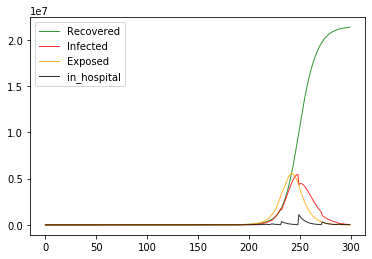

In [13]:
#visualize Hubei Province
sh=output[output['province_en']=='Beijing']
plt.plot(sh['day'],sh['recover'], marker='', color='green', linewidth=1, alpha=0.8, label='Recovered')
#plt.plot(sh['day'],sh['susceptics'], marker='', color='blue', linewidth=1, alpha=0.8, label='Susceptical')
plt.plot(sh['day'],sh['infected'], marker='', color='red', linewidth=1, alpha=0.8, label='Infected')
plt.plot(sh['day'],sh['exposed'], marker='', color='orange', linewidth=1, alpha=0.8, label='Exposed')
plt.plot(sh['day'],sh['in_hospital'], marker='', color='black', linewidth=1, alpha=0.8, label='in_hospital')
plt.legend()

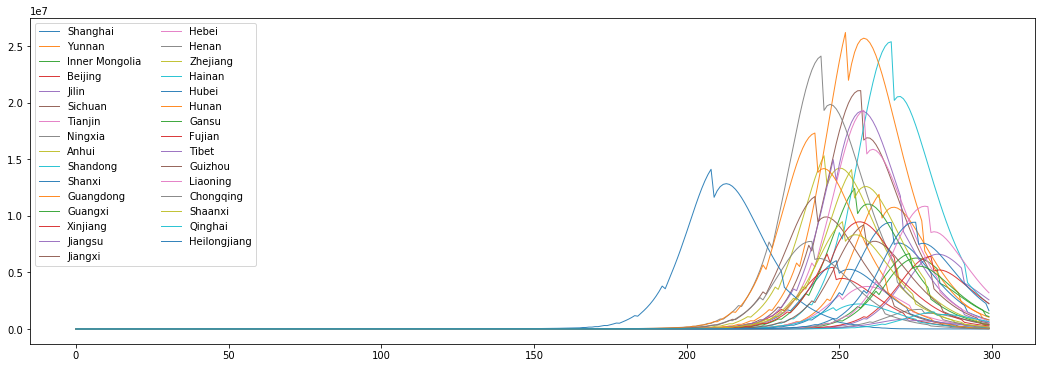

In [14]:
def plotall_province(output,periods):
    #this function plot all provinces simulation.
    output2=output[output['day']<periods]
    fig=plt.figure(figsize=(18,6))
    for i, province in enumerate(output2['province_en'].unique()):
        df=output2[output2['province_en']==province]
        plt.plot(df['day'], df['infected'], marker='', linewidth=1, alpha=0.9, label=province)
    plt.legend(loc=2, ncol=2)
plotall_province(output,300)

In [15]:
def plotall_province_log(output,periods):
    #this function plot all provinces simulation.
    output2=output[output['day']<periods]
    fig=plt.figure(figsize=(18,6))
    for i, province in enumerate(output2['province_en'].unique()):
        df=output2[output2['province_en']==province]
        plt.plot(df['day'], df['infected']+1, marker='', linewidth=1, alpha=0.9, label=province)
        plt.yscale('log')
    plt.legend(loc=2, ncol=2)

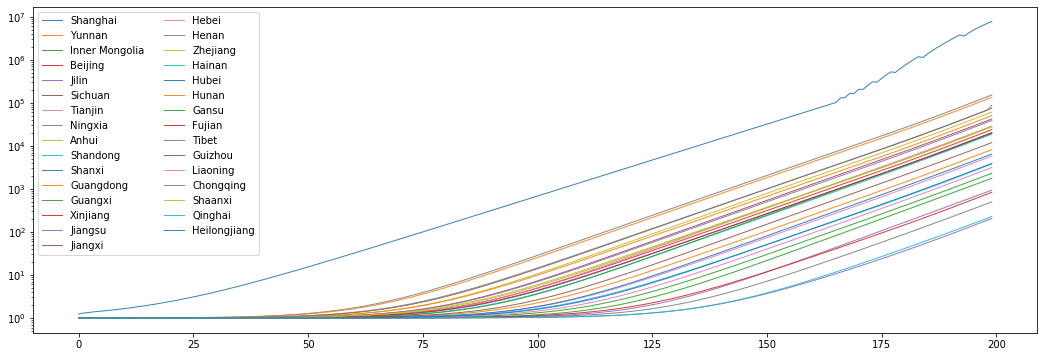

In [16]:
plotall_province_log(output,200)

### This is for you to try:

In [19]:
#change quarantine_start date and visualize the difference
start_date=20 # default value

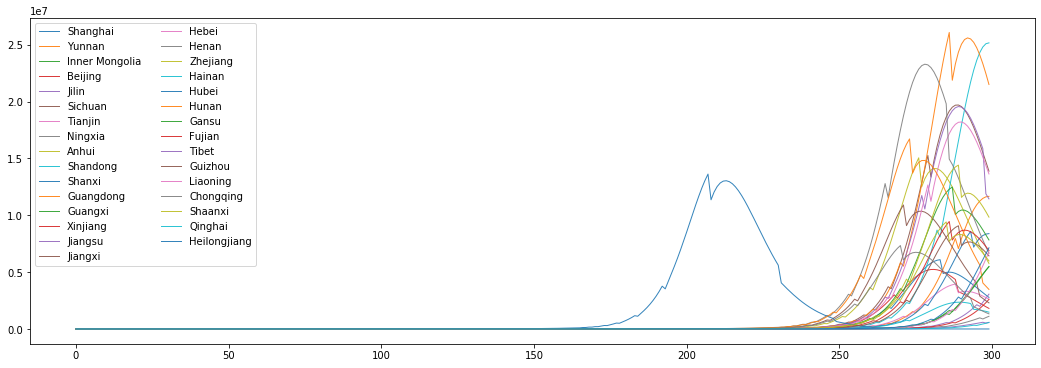

In [21]:
#show Quarantine at day 60 after the first infected person in Hubei
#output=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=300,T=300, addbeds=False)
output_q=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=start_date,T=300,addbeds=False)
plotall_province(output_q,300)
#the results show every province's peak time pushed by about 30 days

Text(0.5, 1.0, "Simulation of Beijing Number of Infected people from the first day of Hubei's infection to the 20th day")

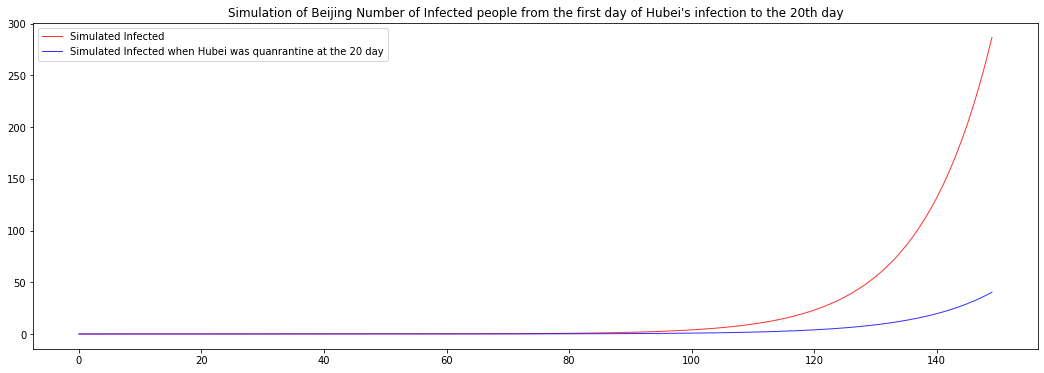

In [22]:
def plotsingleprovince(province_name,day,start_date):
    bj=output[output['province_en']==province_name][:day]
    bj_q=output_q[output_q['province_en']==province_name][:day]
    fig=plt.figure(figsize=(18,6))
    plt.plot(bj['day'],bj['infected'],marker='',color='red',linewidth=1, 
             alpha=0.8,label='Simulated Infected')
    plt.plot(bj_q['day'],bj_q['infected'],marker='',color='blue',linewidth=1, 
             alpha=0.8,label='Simulated Infected when Hubei was quanrantine at the {} day'.format(start_date))
    plt.legend()
    
plotsingleprovince('Beijing',150,start_date)
plt.title("Simulation of Beijing Number of Infected people from the first day of Hubei's infection to the 20th day")

### 4. File to csv/json

In [ ]:
output.to_csv('simulation.csv')
